In [191]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt


In [121]:
clf_trainings = []
plot_classifier_all = []
fpr_dipho_all,tpr_dipho_all = [],[]
fpr_gJets_all,tpr_gJets_all = [],[]
X_total_test_all,y_total_test_all,w_total_test_all = [],[],[]
efficiency_sig_all,efficiency_bkg_all = [],[]
N_sig_all,N_bkg_all = [],[]
labels=[]

In [192]:
year=0
dirs = ['ntuples_2016_20181210','ntuples_2017_20181210']
ntuples = dirs[year]
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
if (year==0) : signal = [s for s in files if "SM_plus_reweighted_nodes_" in s ]
else : signal = [s for s in files if "SM_plus_nodes_" in s ]
diphotonJets = [s for s in files if "DiPhotonJetsBox_" in s]
#diphotonJets_1B = [s for s in files if "DiPhotonJetsBox1B" in s] # will use for limits
#diphotonJets_2B = [s for s in files if "DiPhotonJetsBox2B" in s] # will use for limits
gJets_lowPt = [s for s in files if "GJet_Pt-20to40" in s]
gJets_highPt = [s for s in files if "GJet_Pt-40" in s]

utils.IO.add_signal(ntuples,signal,1,'nodesCombined',year)
utils.IO.add_background(ntuples,diphotonJets,-1,'tagsDumper/trees/'+diphotonJets[0][diphotonJets[0].find('output_')+7:diphotonJets[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)
utils.IO.add_background(ntuples,gJets_lowPt,-2,'tagsDumper/trees/'+gJets_lowPt[0][gJets_lowPt[0].find('output_')+7:gJets_lowPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                            
utils.IO.add_background(ntuples,gJets_highPt,-2,'tagsDumper/trees/'+gJets_highPt[0][gJets_highPt[0].find('output_')+7:gJets_highPt[0].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0',year)                           


for i in range(len(utils.IO.backgroundName)):        
    print "using background file n."+str(i)+": "+utils.IO.backgroundName[i]
for i in range(len(utils.IO.signalName)):    
    print "using signal file n."+str(i)+": "+utils.IO.signalName[i]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20181210
using background file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20181210/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root
using background file n.1: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20181210/output_GJet_Pt-20to40_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using background file n.2: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20181210/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root
using signal file n.0: /shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2016_20181210/output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root


## Folder name where to store output for a specific training

In [193]:
outstr = "20_12_2018_commonTraining_2016_resWeightin"
labels.append(outstr)
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr
if not os.path.exists(utils.IO.plotFolder):
    print utils.IO.plotFolder, "doesn't exist, creating it..."
    os.makedirs(utils.IO.plotFolder)

In [194]:
plt.clf()
doReweight2017 = True #reweight signal from 2017 to match 2016 (mix of nodes reweight with HH_mass at gen level)
if (year==1 and doReweight2017 == True):
    sigFiles = ['output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root','output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root']
    genFrame2017=rpd.read_root(utils.IO.ldata+dirs[1]+'/'+sigFiles[1],'GenNodesCombined', columns = ['mhh','weight'])
    genFrame2016=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'GenNodesCombined', columns = ['mhh','weight'])
    recoFrame2016=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'nodesCombined', columns = ['MX','genMhh','weight'])
    recoFrame2017=rpd.read_root(utils.IO.ldata+dirs[1]+'/'+sigFiles[1],'nodesCombined', columns = ['MX','genMhh','weight'])

    
    n, bins, patches = plt.hist(genFrame2016['mhh'], np.linspace(200,2000,100), facecolor='b',weights=genFrame2016['weight'], alpha=0.5,normed=False,label='2016')
    plt.xlabel('gen M(HH) [GeV]')
    plt.ylabel('A.U.')
    n_2017, bins_2017, patches_2017 = plt.hist(genFrame2017['mhh'], bins=bins,weights=genFrame2017['weight'],facecolor='r', alpha=0.3,normed=False,label='2017')
    plt.legend(loc = 'upper right')
    plt.show()
    

In [195]:
from ROOT import TLorentzVector

#use noexpand for root expressions, it needs this file https://github.com/ibab/root_pandas/blob/master/root_pandas/readwrite.py
########################new code branches############################
#branch_names = 'leadingJet_bDis,subleadingJet_bDis,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverMDecorr,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
branch_names = 'leadingJet_DeepCSV,subleadingJet_DeepCSV,absCosThetaStar_CS,absCosTheta_bb,absCosTheta_gg,diphotonCandidatePtOverdiHiggsM,dijetCandidatePtOverdiHiggsM,customLeadingPhotonIDMVA,customSubLeadingPhotonIDMVA,leadingPhotonSigOverE,subleadingPhotonSigOverE,sigmaMOverM,PhoJetMinDr'.split(",") #set of variables March 2017 but regressed
b_reg_branches = 'noexpand:(leadingJet_bRegNNResolution*1.4826),noexpand:(subleadingJet_bRegNNResolution*1.4826),noexpand:(sigmaMJets*1.4826)'.split(",")
branch_cuts = 'leadingJet_pt,subleadingJet_pt,leadingJet_bRegNNCorr,subleadingJet_bRegNNCorr,noexpand:(leadingJet_pt/leadingJet_bRegNNCorr),noexpand:(subleadingJet_pt/subleadingJet_bRegNNCorr)'.split(',')
cuts = 'leadingJet_pt>0'
#cuts = 'subleadingJet_pt>25'
######################

#event_branches = ['event','sigmaMOverM','noexpand:(dijetSigmaMOverM*1.4826)']
event_branches = ['event','weight','MX','leadingJet_hflav','leadingJet_pflav','subleadingJet_hflav','subleadingJet_pflav']

branch_names = branch_names + ['rho']
branch_names = branch_names+b_reg_branches
resolution_weighting = 'ggbb' # None, gg or ggbb
doOverlapRemoval=False   #diphotons overlap removal if using b-enriched samples


branch_names = [c.strip() for c in branch_names]
print branch_names

event_bkg,event_sig = None,None
if (year==1 and doReweight2017 == True):
    preprocessing.set_signals(branch_names+event_branches+branch_cuts+['genMhh'],True,cuts)
    preprocessing.set_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)
else :
    preprocessing.set_signals_and_backgrounds(branch_names+event_branches+branch_cuts,True,cuts)


if 'gg' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='sigmaMOverM')
if 'bb' in resolution_weighting : 
    preprocessing.weight_signal_with_resolution_all(branch='(sigmaMJets*1.4826)')

if doOverlapRemoval == True:    
    for i in range(utils.IO.nBkg):
        if 'DiPhotonJetsBox_MGG' in utils.IO.bkgTreeName[i] : preprocessing.cleanOverlapDiphotons(utils.IO.bkgTreeName[i],utils.IO.background_df[i])        

if (year==1 and doReweight2017 == True):
    preprocessing.reweight_gen_mhh('mhh',genFrame2016,genFrame2017,utils.IO.signal_df[0],'genMhh')
                    
        
X_bkg,y_bkg,weights_bkg,event_bkg,X_sig,y_sig,weights_sig,event_sig=preprocessing.set_variables(branch_names,use_event_num=True)

info_file = open(utils.IO.plotFolder+"info_%s.txt"%outstr,"w") 
info_file.write("\n".join(branch_names))
info_file.write("Resolution weighting : %s\n"%resolution_weighting)
info_file.write("Cuts : %s\n"%cuts)
info_file.close()



X_bkg,y_bkg,weights_bkg,event_bkg = preprocessing.randomize(X_bkg,y_bkg,weights_bkg,event_num = np.asarray(event_bkg))
X_sig,y_sig,weights_sig,event_sig = preprocessing.randomize(X_sig,y_sig,weights_sig,event_num = np.asarray(event_sig))


#Get training and test samples based on event number : even/odd or %5, set in the function for now
y_total_train = preprocessing.get_total_training_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_train = preprocessing.get_total_training_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

y_total_test = preprocessing.get_total_test_sample_event_num(y_sig.reshape(-1,1),y_bkg,event_sig.reshape(-1,1),event_bkg).ravel()
X_total_test = preprocessing.get_total_test_sample_event_num(X_sig,X_bkg,event_sig.reshape(-1,),event_bkg.reshape(-1,))

w_total_train = preprocessing.get_total_training_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()
w_total_test = preprocessing.get_total_test_sample_event_num(weights_sig.reshape(-1,1),weights_bkg.reshape(-1,1),event_sig.reshape(-1,1),event_bkg).ravel()


##########Normalize weights for training and testing. Sum(signal)=Sum(bkg)=1. But keep relative normalization
# between bkg classes
w_total_train = preprocessing.normalize_process_weights_split_all(w_total_train,y_total_train)
w_total_test = preprocessing.normalize_process_weights_split_all(w_total_test,y_total_test)


['leadingJet_DeepCSV', 'subleadingJet_DeepCSV', 'absCosThetaStar_CS', 'absCosTheta_bb', 'absCosTheta_gg', 'diphotonCandidatePtOverdiHiggsM', 'dijetCandidatePtOverdiHiggsM', 'customLeadingPhotonIDMVA', 'customSubLeadingPhotonIDMVA', 'leadingPhotonSigOverE', 'subleadingPhotonSigOverE', 'sigmaMOverM', 'PhoJetMinDr', 'rho', 'noexpand:(leadingJet_bRegNNResolution*1.4826)', 'noexpand:(subleadingJet_bRegNNResolution*1.4826)', 'noexpand:(sigmaMJets*1.4826)']
using tree:nodesCombined
using tree:tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_20to40_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0
using tree:tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0


In [196]:
print '-'*10,'For train','-'*10
print 'Signal : ',y_total_train[np.where(y_total_train==1)].shape[0]
print 'Bkg : ',y_total_train[np.where(y_total_train!=1)].shape[0]
print '-'*10,'For test','-'*10
print 'Signal : ',y_total_test[np.where(y_total_test==1)].shape[0]
print 'Bkg : ',y_total_test[np.where(y_total_test!=1)].shape[0]
print '-'*55
print '-'*10,'Normalizitation for the training','-'*10
print 'Sum of weights sig : %.2f'%(np.sum(w_total_train[np.where(y_total_train==1)]))
print 'Sum of weights bkg : %.2f'%(np.sum(w_total_train[np.where(y_total_train!=1)]))
print 'Sum of weights bkg -1 : %.2f'%(np.sum(w_total_train[np.where(y_total_train==-1)]))
print 'Sum of weights bkg -2 : %.2f'%(np.sum(w_total_train[np.where(y_total_train==-2)]))
print 'Ratio of sum of weights bkg -2/-1 : %.2f'%((np.sum(w_total_train[np.where(y_total_train==-2)]))/(np.sum(w_total_train[np.where(y_total_train==-1)])))
print '-'*10,'Normalizitation for the testing','-'*10
print 'Sum of weights sig : %.2f'%(np.sum(w_total_test[np.where(y_total_test==1)]))
print 'Sum of weights bkg : %.2f'%(np.sum(w_total_test[np.where(y_total_test!=1)]))
print 'Sum of weights bkg -1 : %.2f'%(np.sum(w_total_test[np.where(y_total_test==-1)]))
print 'Sum of weights bkg -2 : %.2f'%(np.sum(w_total_test[np.where(y_total_test==-2)]))
print 'Ratio of sum of weights bkg -2/-1 : %.2f'%((np.sum(w_total_test[np.where(y_total_test==-2)]))/(np.sum(w_total_test[np.where(y_total_test==-1)])))

print '-'*55

efficiency_sig = np.sum(weights_sig[np.where(y_sig==1)])
efficiency_bkg = np.sum(weights_bkg[np.where(y_bkg!=1)])

print '-'*10,'Efficiency of signal and background','-'*10
print 'Signal after %s weighting : %.3f'%(resolution_weighting,efficiency_sig)
print 'Background : %.3f'%(efficiency_bkg)


---------- For train ----------
Signal :  611675
Bkg :  325743
---------- For test ----------
Signal :  613762
Bkg :  81059
-------------------------------------------------------
---------- Normalizitation for the training ----------
Sum of weights sig : 1.00
Sum of weights bkg : 1.00
Sum of weights bkg -1 : 0.49
Sum of weights bkg -2 : 0.51
Ratio of sum of weights bkg -2/-1 : 1.05
---------- Normalizitation for the testing ----------
Sum of weights sig : 1.00
Sum of weights bkg : 1.00
Sum of weights bkg -1 : 0.49
Sum of weights bkg -2 : 0.51
Ratio of sum of weights bkg -2/-1 : 1.05
-------------------------------------------------------
---------- Efficiency of signal and background ----------
Signal after bb weighting : 26.560
Background : 1964.014


In [197]:
#Save the data from one training
efficiency_sig_all.append(efficiency_sig)
efficiency_bkg_all.append(efficiency_bkg)
if year==0 : N_sig_all.append(np.sum(recoFrame2016['weight'])) #have to read it directly from the frame 
####because otherwise it is weighted with inverse resolution
if year==1 : N_sig_all.append(np.sum(recoFrame2017['weight']))
N_bkg_all.append(efficiency_bkg)
X_total_test_all.append(X_total_test)
y_total_test_all.append(y_total_test)
w_total_test_all.append(w_total_test)

In [198]:
print N_sig_all, N_bkg_all

[2.609320423561503, 2.609320423561503, 2.609320423561503, 2.609320423561503, 2.609320423561503] [1964.0143, 1964.0143, 1964.0143, 1964.0143, 1964.0143]


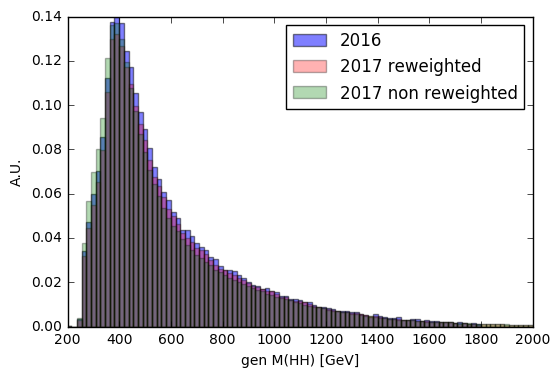

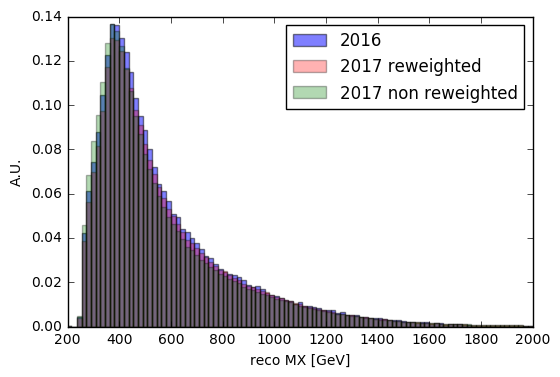

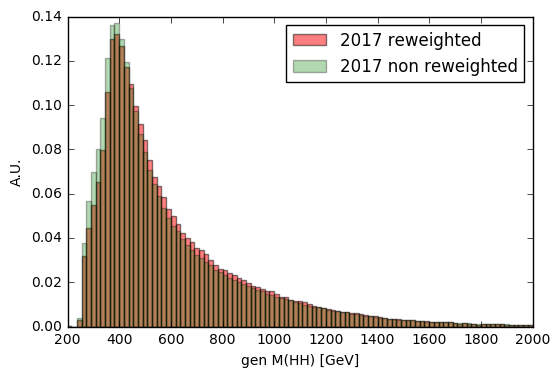

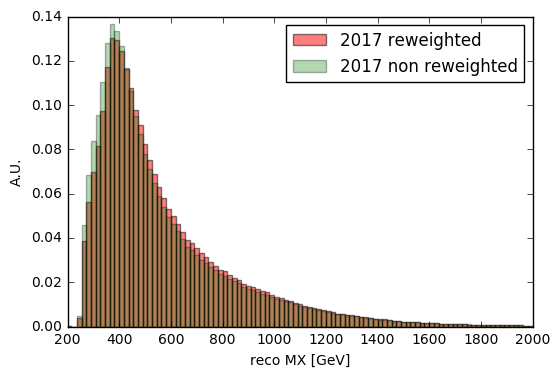

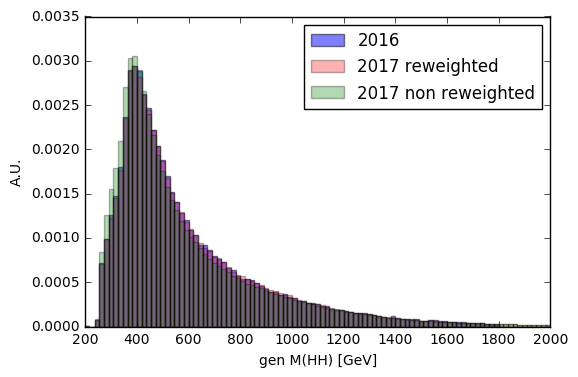

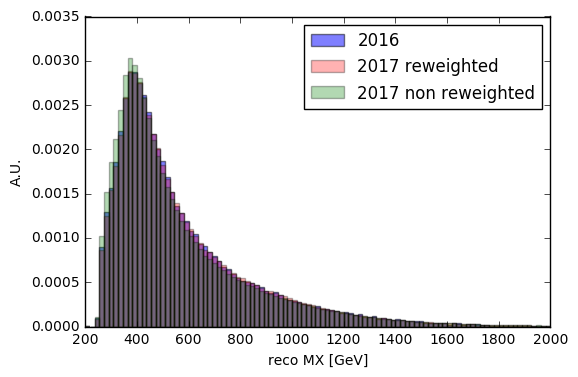

In [101]:
plt.clf()
n, bins, patches = plt.hist(recoFrame2016['genMhh'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=False,label='2017 reweighted')
n, bins, patches = plt.hist(recoFrame2017['genMhh'], bins=bins, facecolor='g',weights=recoFrame2017['weight'], alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_1_"+"_"+str(outstr)+".pdf" ,bbox_inches='tight')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_1_"+"_"+str(outstr)+".png", bbox_inches='tight')
plt.show()

plt.clf()
n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=False,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_2_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_2_"+"_"+str(outstr)+".png")
plt.show()



#n, bins, patches = plt.hist(recoFrame2016['hh_m'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], np.linspace(200,2000,100),weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.5,normed=False,label='2017 reweighted')
n, bins, patches = plt.hist(recoFrame2017['genMhh'], bins=bins, facecolor='g',weights=recoFrame2017['weight'], alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_3_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_3_"+"_"+str(outstr)+".png")
plt.show()


#n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=False,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], np.linspace(200,2000,100),weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.5,normed=False,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=False,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_4_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_4_"+"_"+str(outstr)+".png")
plt.show()


n, bins, patches = plt.hist(recoFrame2016['genMhh'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=True,label='2016')
plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['genMhh'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=True,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['genMhh'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=True,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_5_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_5_"+"_"+str(outstr)+".png")
plt.show()


n, bins, patches = plt.hist(recoFrame2016['MX'], np.linspace(200,2000,100), facecolor='b',weights=recoFrame2016['weight'], alpha=0.5,normed=True,label='2016')
plt.xlabel('reco MX [GeV]')
plt.ylabel('A.U.')
n_2017, bins_2017, patches_2017 = plt.hist(utils.IO.signal_df[0]['MX'], bins=bins,weights=utils.IO.signal_df[0]['weight'],facecolor='r', alpha=0.3,normed=True,label='2017 reweighted')
n_2017, bins_2017, patches_2017 = plt.hist(recoFrame2017['MX'], bins=bins,weights=recoFrame2017['weight'],facecolor='g', alpha=0.3,normed=True,label='2017 non reweighted')
plt.legend(loc = 'upper right')
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_6_"+"_"+str(outstr)+".pdf")
plt.savefig(utils.IO.plotFolder+"compare_2016_2017_6_"+"_"+str(outstr)+".png")
plt.show()



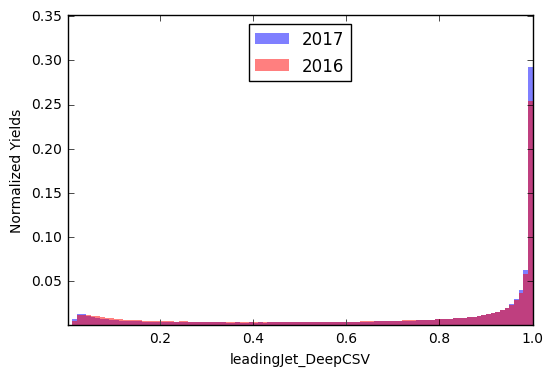

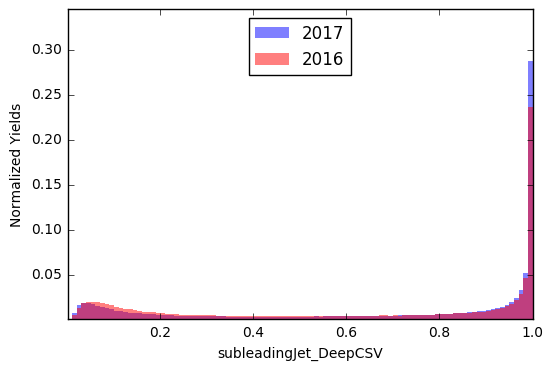

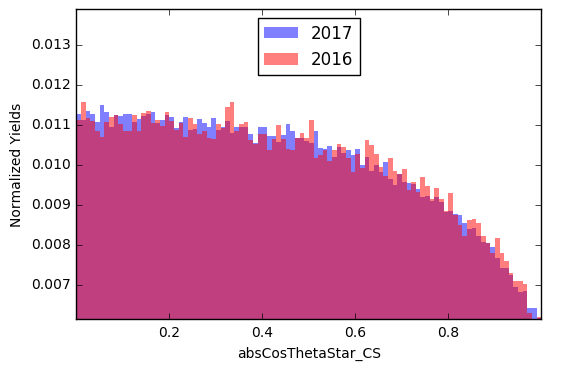

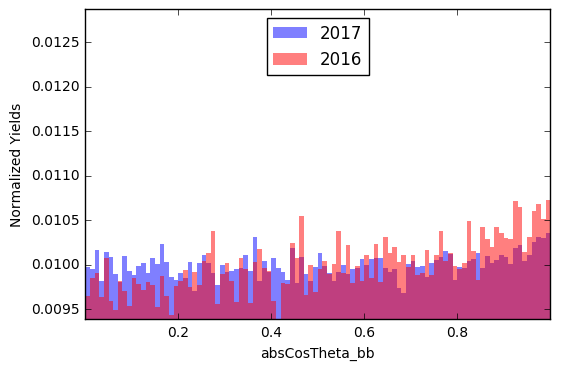

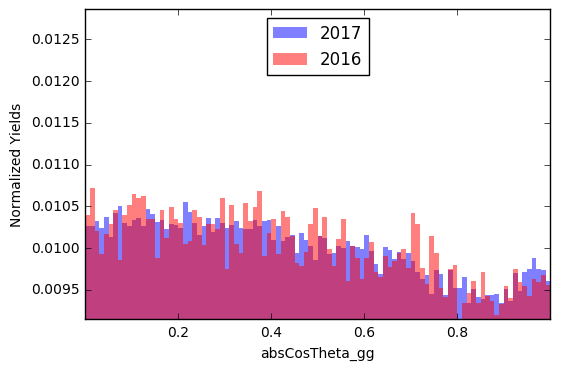

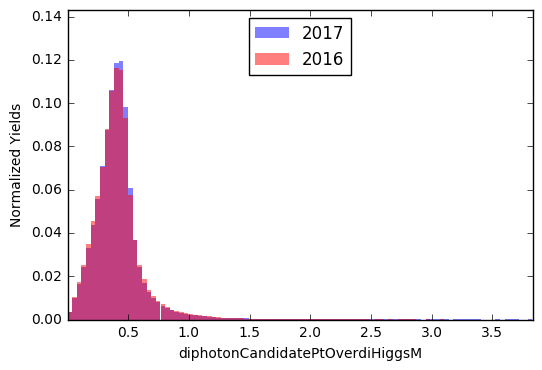

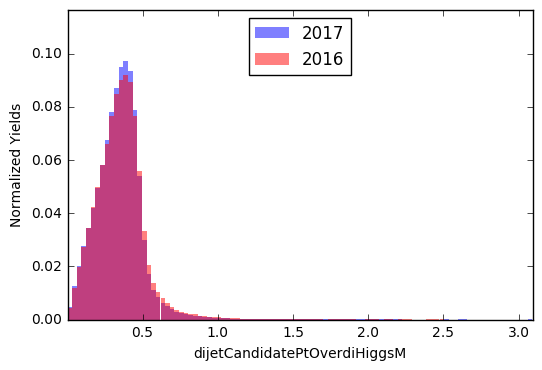

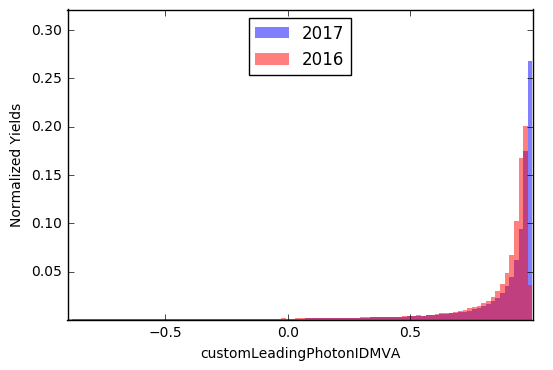

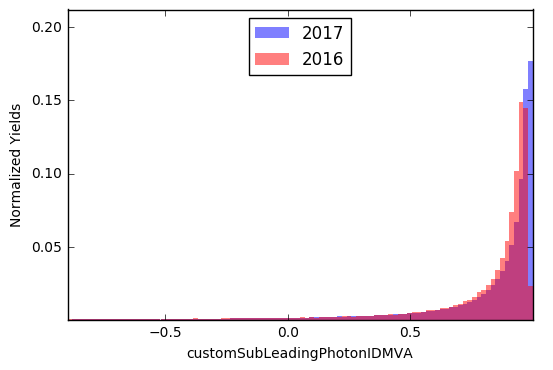

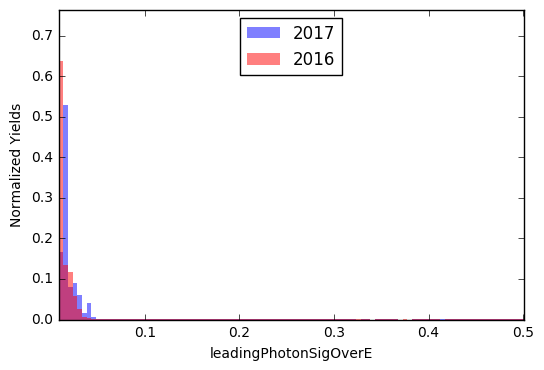

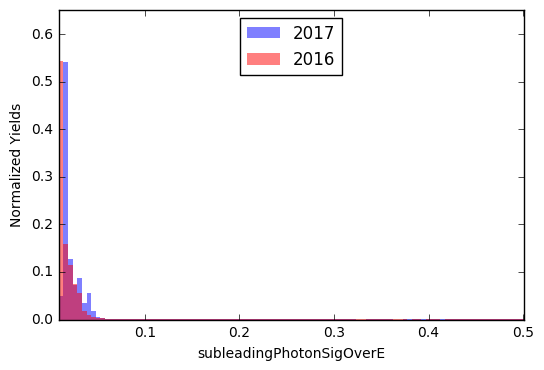

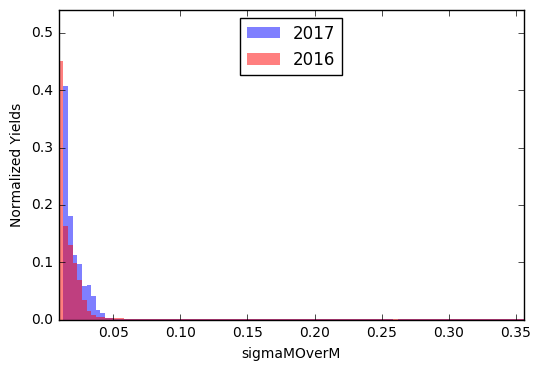

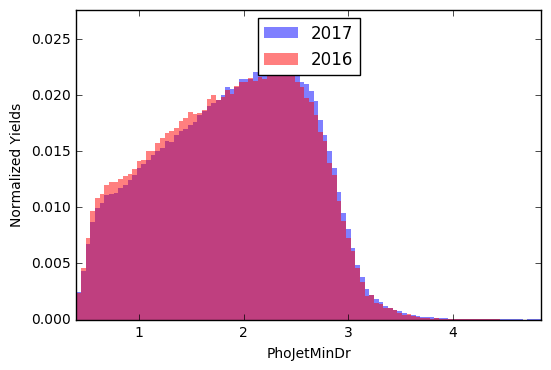

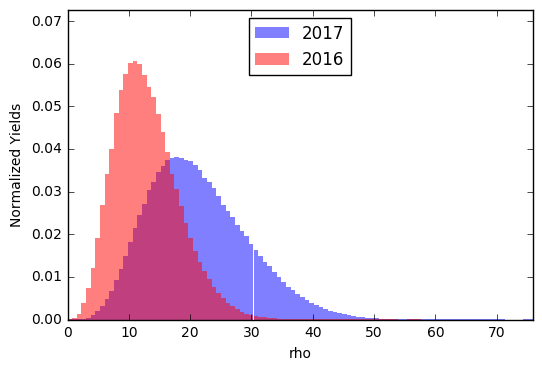

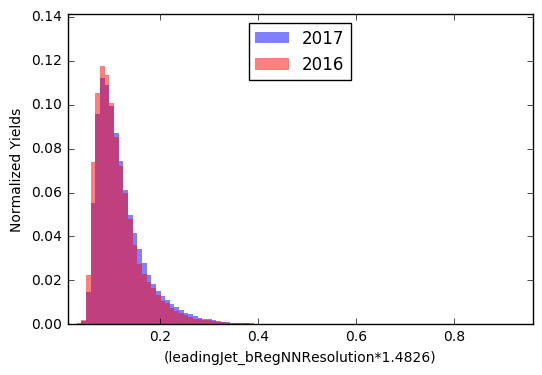

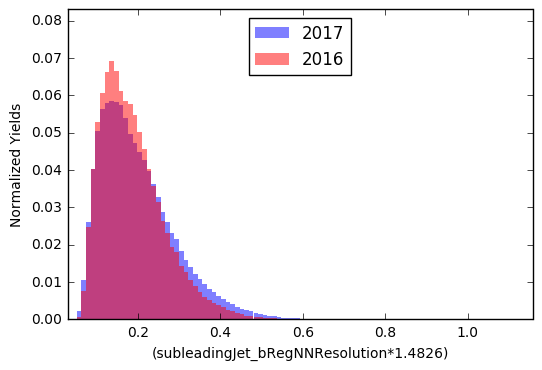

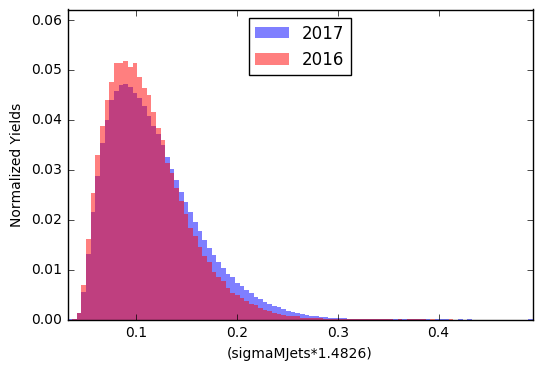

In [58]:
#Plot 2016 vs 2017 :
plt.clf()
br_names = [item.replace('noexpand:','') for item in branch_names]
recoFrame2016_full=rpd.read_root(utils.IO.ldata+dirs[0]+'/'+sigFiles[0],'nodesCombined',columns=branch_names+['weight','MX','genMhh'])
plotting.plot_input_variables_weights(utils.IO.signal_df[0][br_names].values,recoFrame2016_full[br_names].values,utils.IO.signal_df[0]['weight'].values.reshape(-1,),recoFrame2016_full['weight'].values.reshape(-1,),branch_names,None,100,'_2016_2017_mix_nodes_genMhhReweighted_normalized',labels=['2017','2016'],normalize=True)

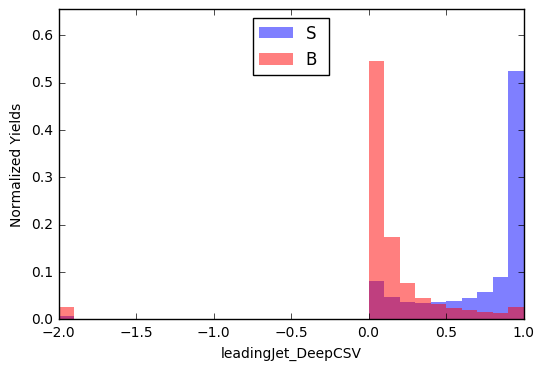

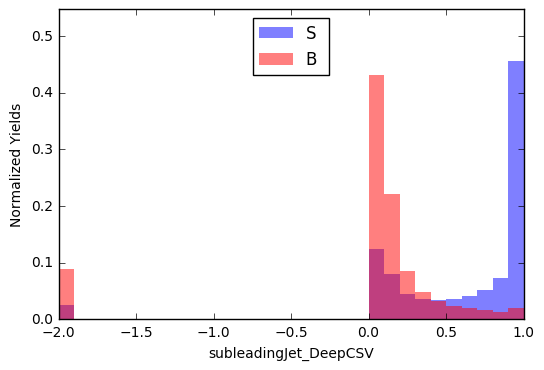

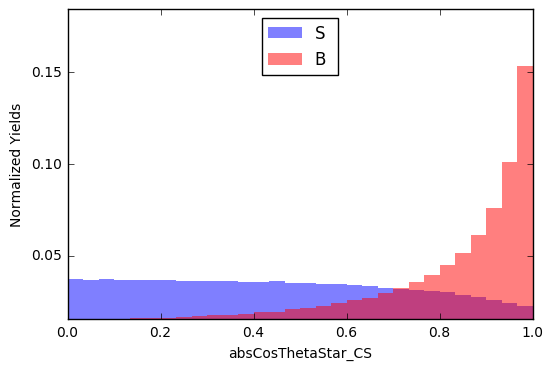

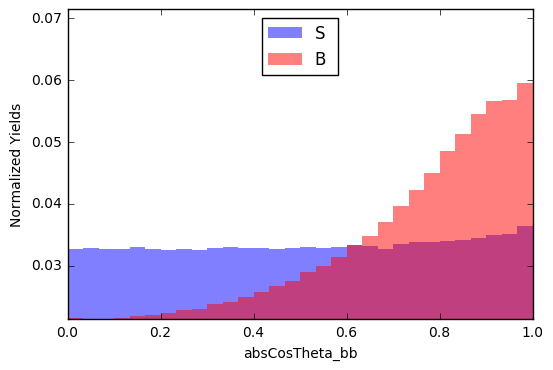

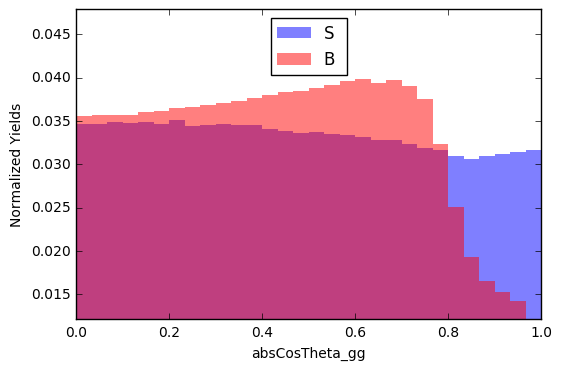

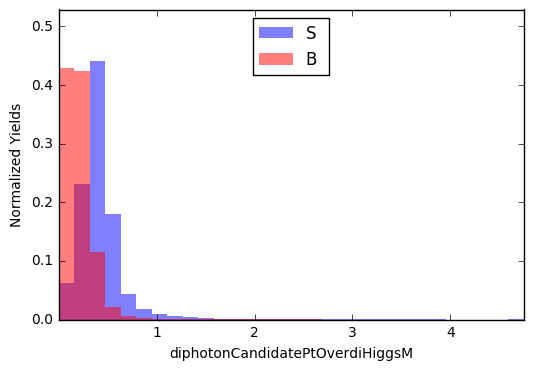

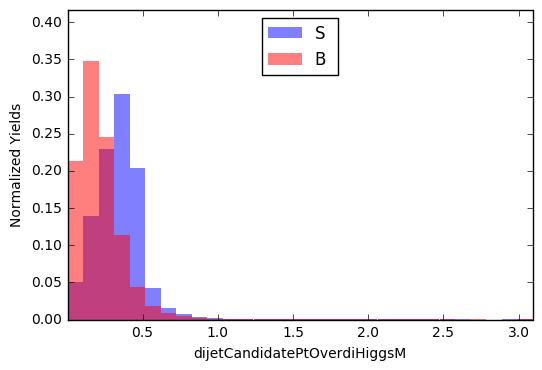

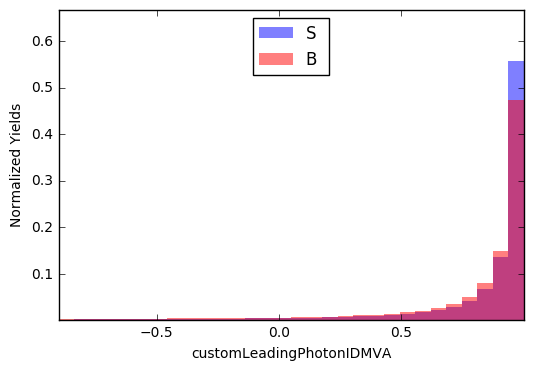

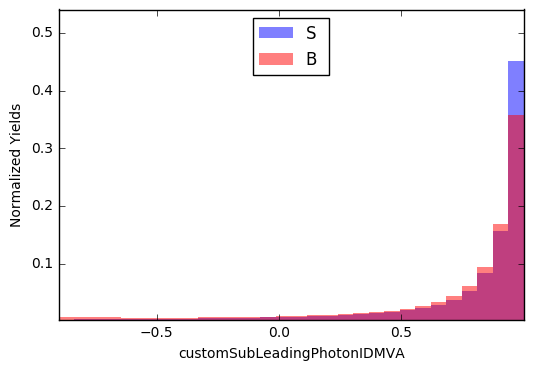

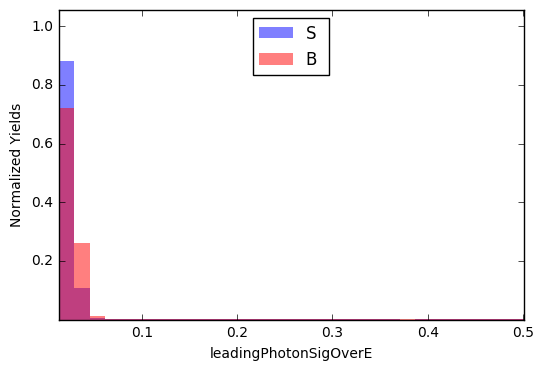

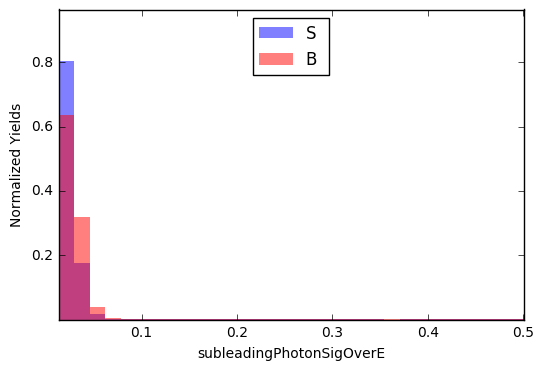

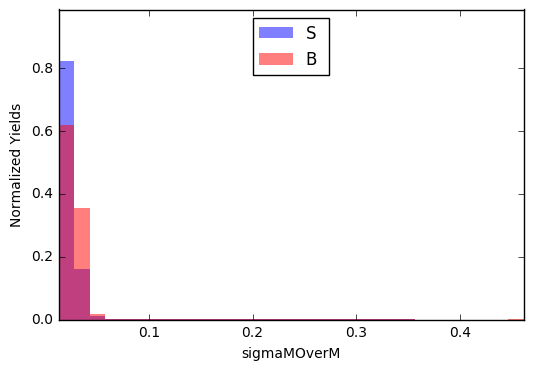

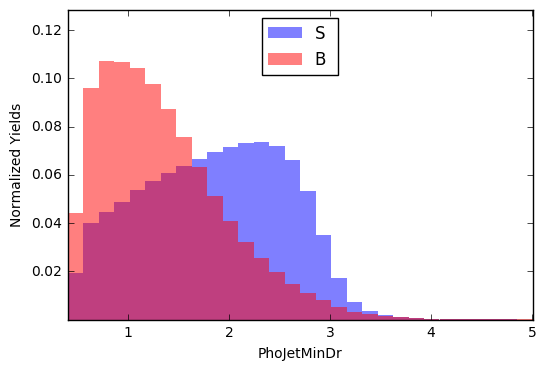

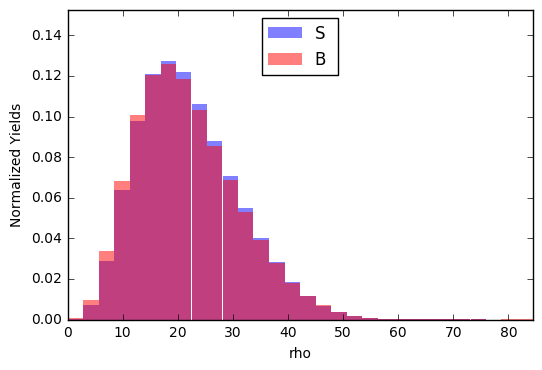

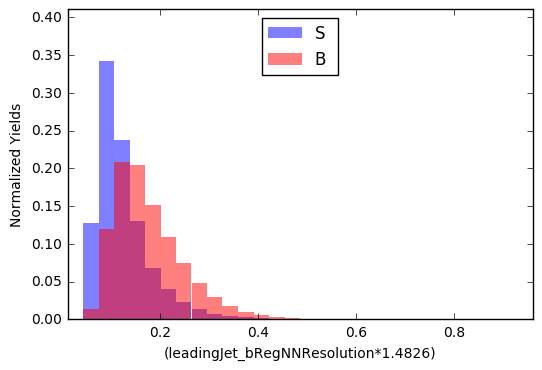

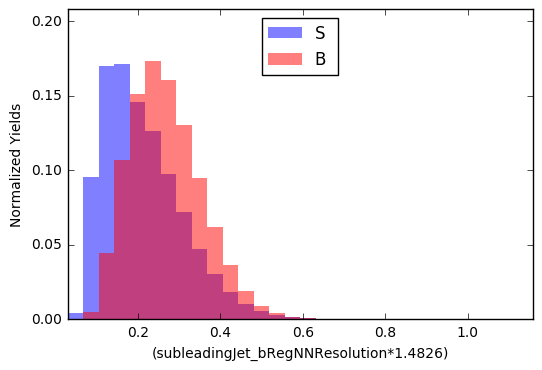

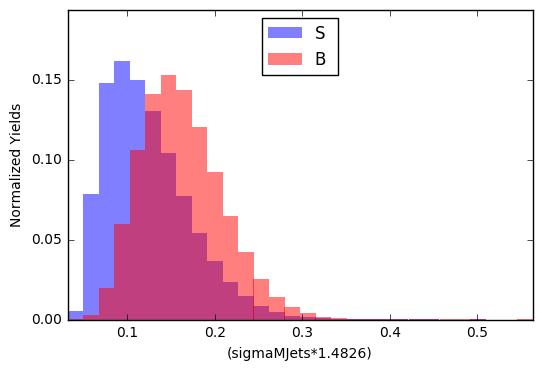

In [83]:
plotting.plot_input_variables(X_sig,X_bkg,branch_names+branch_cuts,None,30,'signalBkg_2017')

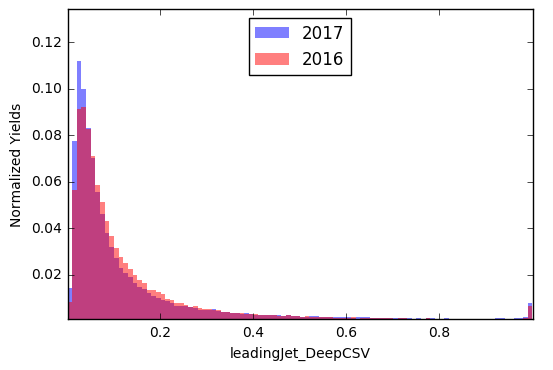

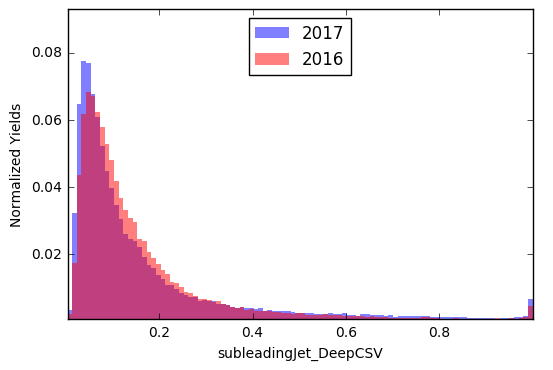

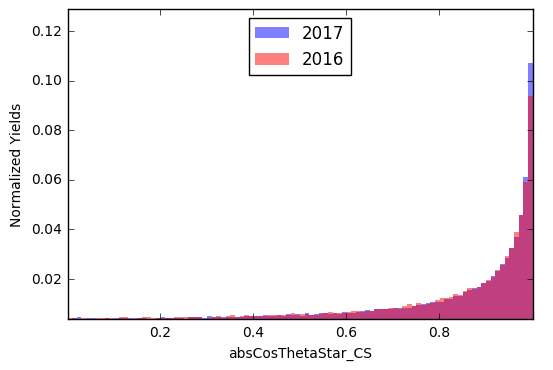

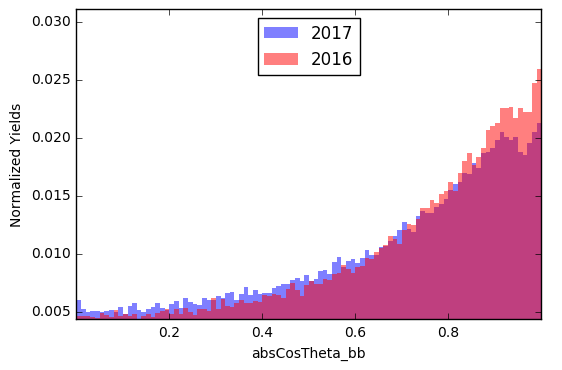

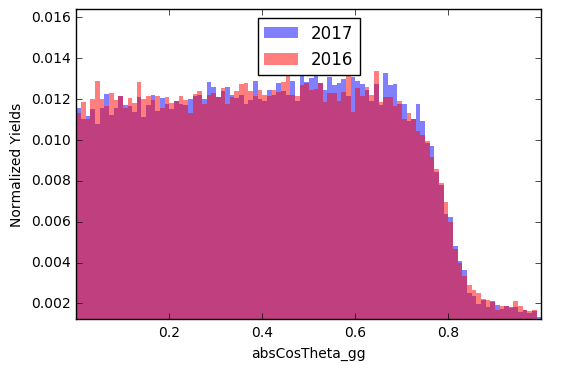

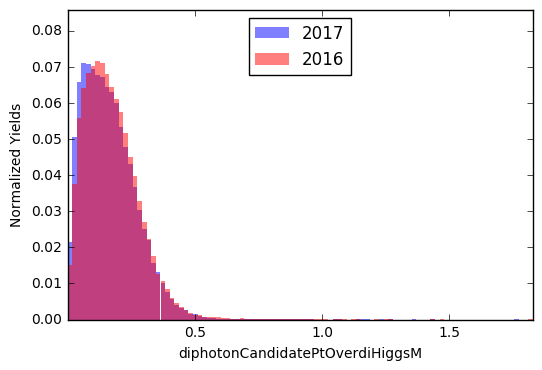

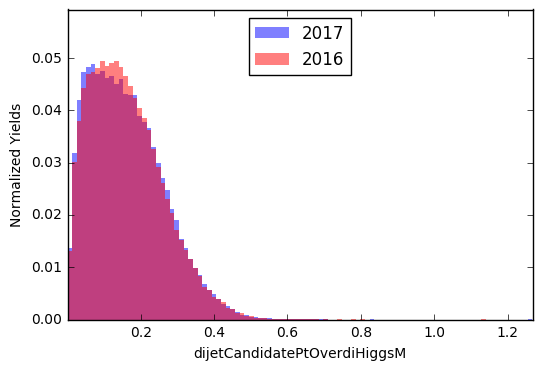

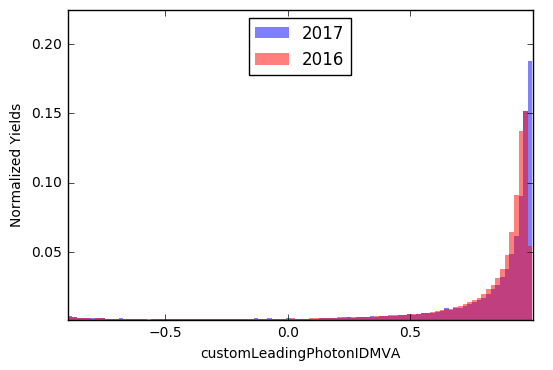

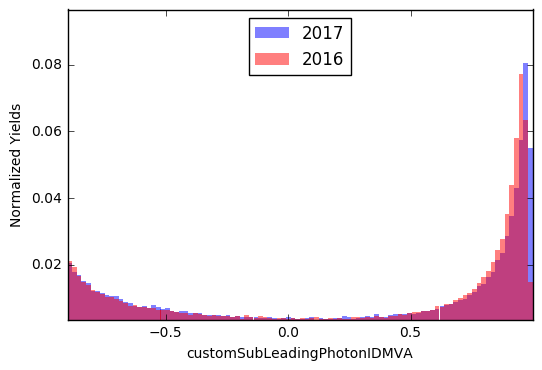

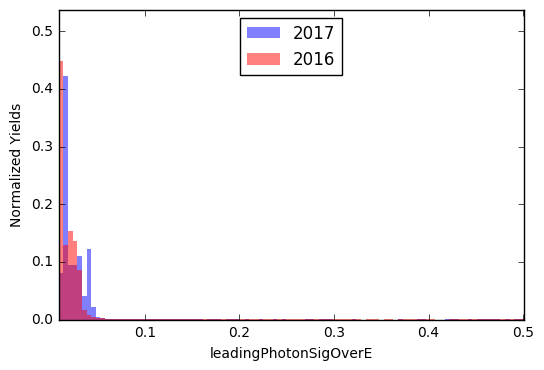

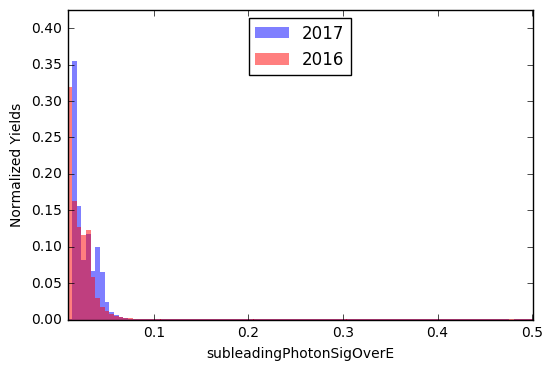

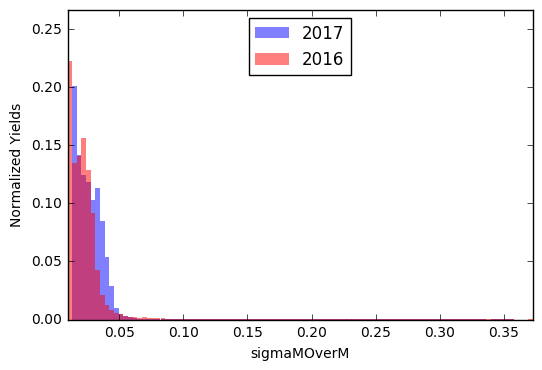

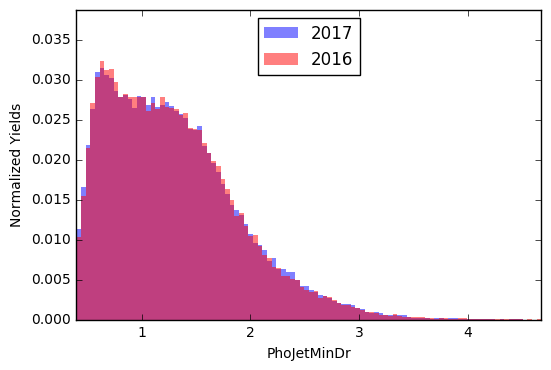

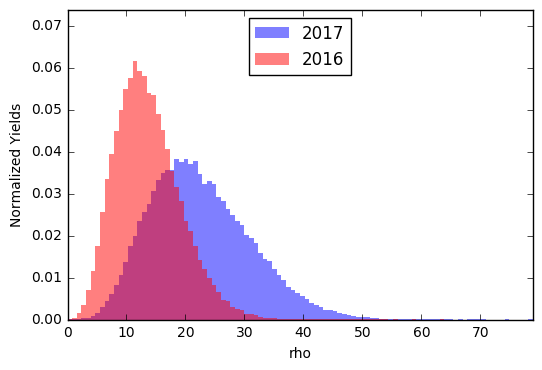

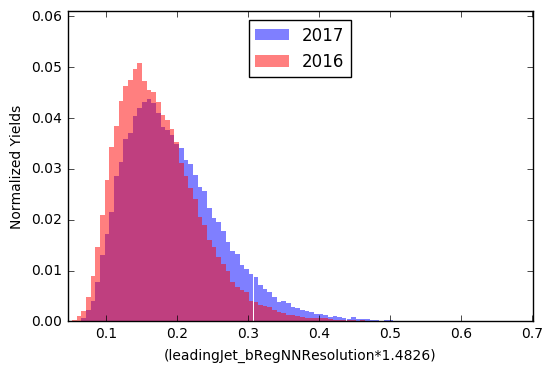

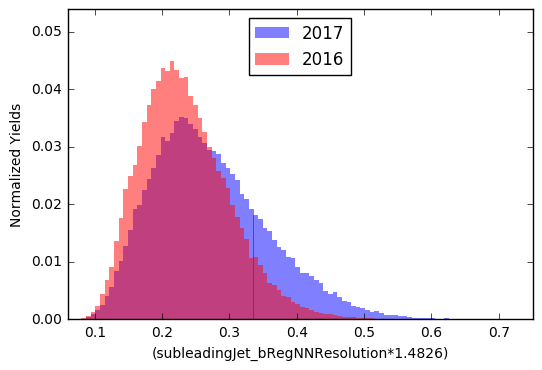

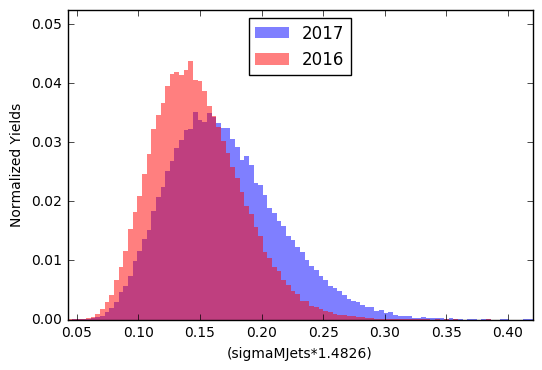

In [50]:
#Plot 2016 vs 2017 :
plt.clf()
br_names = [item.replace('noexpand:','') for item in branch_names]
#recoFrame2017bkg_full=rpd.read_root(utils.IO.ldata+dirs[1]+'/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root','tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh'])
#recoFrame2016bkg_full=rpd.read_root(utils.IO.ldata+dirs[0]+'/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root','tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh'])
recoFrame2017bkg_full=rpd.read_root(utils.IO.ldata+dirs[1]+'/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCP5_13TeV_Pythia8.root','tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCP5_13TeV_Pythia8_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh'])
recoFrame2016bkg_full=rpd.read_root(utils.IO.ldata+dirs[0]+'/output_GJet_Pt-40toInf_DoubleEMEnriched_MGG-80toInf_TuneCUETP8M1_13TeV_Pythia8.root','tagsDumper/trees/GJet_Pt_40toInf_DoubleEMEnriched_MGG_80toInf_TuneCUETP8M1_13TeV_Pythia8_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh'])
plotting.plot_input_variables_weights(recoFrame2017bkg_full[br_names].values,recoFrame2016bkg_full[br_names].values,recoFrame2017bkg_full['weight'],recoFrame2016bkg_full['weight'].values.reshape(-1,),branch_names,None,100,'_2016_2017_gJets40Inf_normalized',labels=['2017','2016'],normalize=True)

In [67]:
#Plot 2016 vs 2017 :
br_names = [item.replace('noexpand:','') for item in branch_names]
bb_names = 'subleadingJet_pt,leadingJet_pt,dijet_pt,dijet_eta,dijet_phi,Mjj'.split(',')
recoFrame2017bkg_full=rpd.read_root(utils.IO.ldata+dirs[1]+'/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root','tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh']+bb_names)
recoFrame2016bkg_full=rpd.read_root(utils.IO.ldata+dirs[0]+'/output_DiPhotonJetsBox_MGG-80toInf_13TeV-Sherpa.root','tagsDumper/trees/DiPhotonJetsBox_MGG_80toInf_13TeV_Sherpa_13TeV_DoubleHTag_0',columns=branch_names+['weight','MX','genMhh']+bb_names)

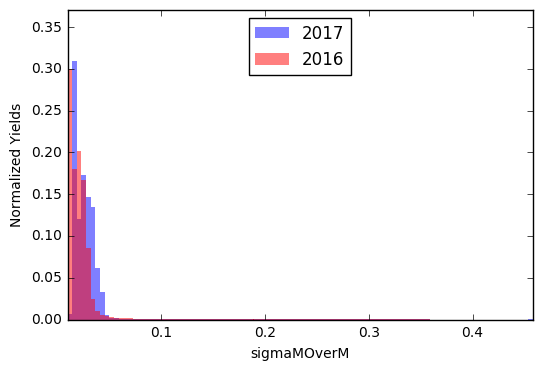

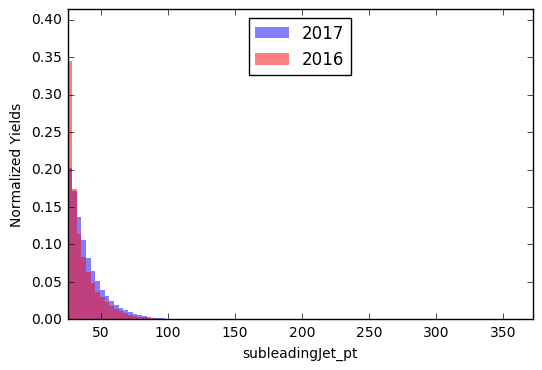

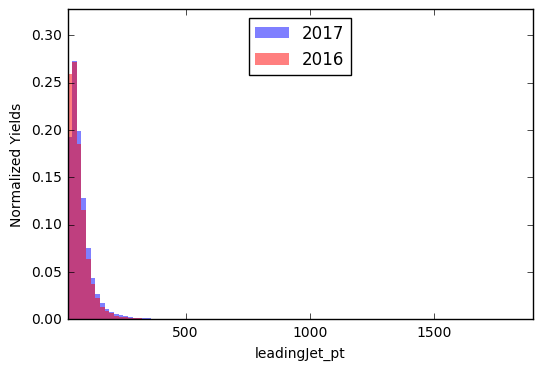

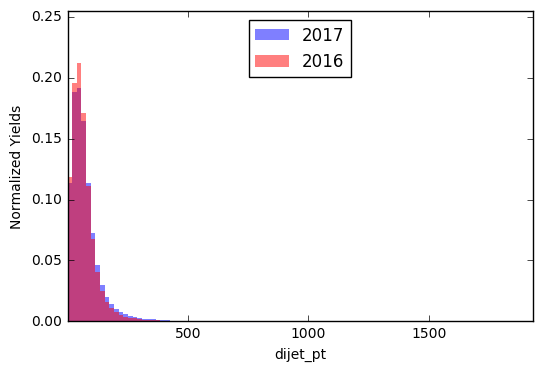

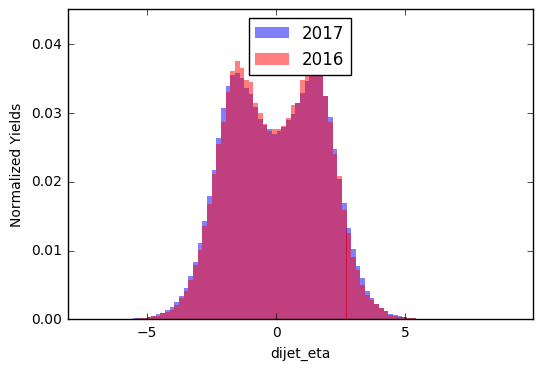

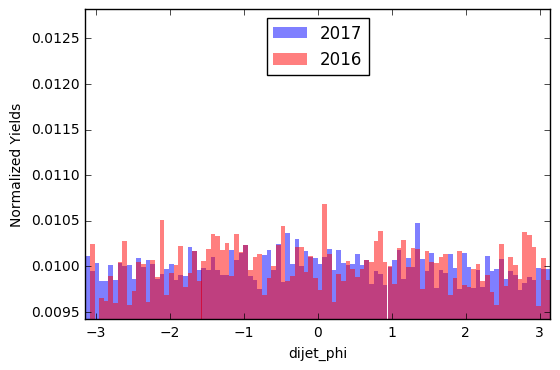

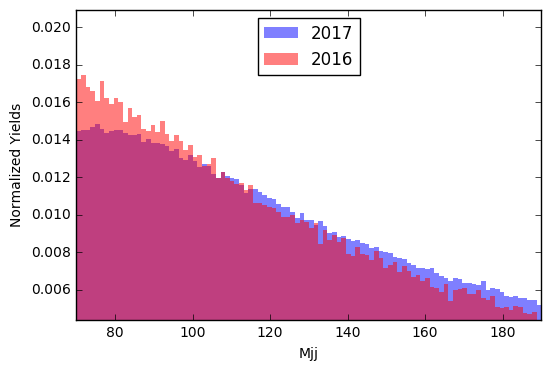

In [68]:
#Plot 2016 vs 2017 :
reload(plotting)
plt.clf()
plotting.plot_input_variables_weights(recoFrame2017bkg_full[bb_names].values,recoFrame2016bkg_full[bb_names].values,recoFrame2017bkg_full['weight'],recoFrame2016bkg_full['weight'].values.reshape(-1,),bb_names,None,100,'_2016_2017_DiPhotons_some_normalized',labels=['2017','2016'],normalize=True)

In [199]:
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
#optimized parameters

clf = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
       max_depth=10, min_child_weight=1e-05, missing=None,
       n_estimators=1000, n_jobs=1, nthread=20, objective='binary:logistic',
       random_state=0, reg_alpha=0.0, reg_lambda=0.1, scale_pos_weight=1,
       seed=0, silent=True, subsample=1)

#the smallest classifier from optimized grid
grid={'reg_alpha': 0.0, 'learning_rate': 0.2, 'min_child_weight': 0.0001, 'n_estimators': 1000, 'reg_lambda': 0.05, 'max_depth': 3, 'gamma': 0}
clf.set_params(**grid)

clf.fit(X_total_train,y_total_train, sample_weight=w_total_train)
joblib.dump(clf, os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_%s.pkl'%outstr), compress=9)
clf_trainings.append(clf)

In [139]:
########final optimization with all fixed#######
from sklearn.externals import joblib
import xgboost as xgb
clf = joblib.load(os.path.expanduser('/shome/nchernya/HHbbgg_ETH_devel/Training/output_files/training_with_10_12_2018_commonTraining_2016.pkl'))
clf_trainings.append(clf)

In [200]:
clf_trainings

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
        max_depth=3, min_child_weight=0.0001, missing=None,
        n_estimators=1000, n_jobs=1, nthread=20, objective='multi:softprob',
        random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
        seed=0, silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
        max_depth=3, min_child_weight=0.0001, missing=nan,
        n_estimators=1000, n_jobs=1, nthread=20, objective='multi:softprob',
        random_state=0, reg_alpha=0.0, reg_lambda=0.05, scale_pos_weight=1,
        seed=0, silent=True, subsample=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.2, max_delta_step=0,
        max_depth=3, min_child_weight=0.0001, missing=Non

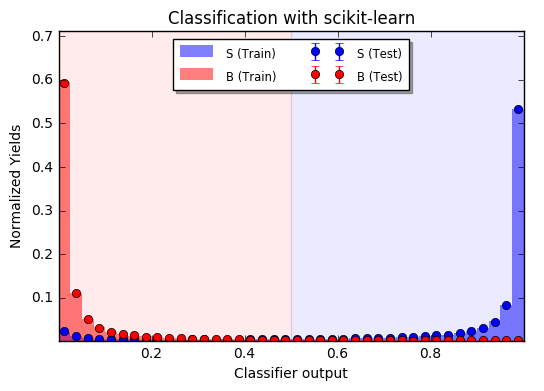

In [107]:
plt.clf()
plot_classifier = plotting.plot_classifier_output(clf,X_total_train,X_total_test,y_total_train,y_total_test,outString=outstr)
plt.show()

plot_classifier_all.append(plot_classifier)

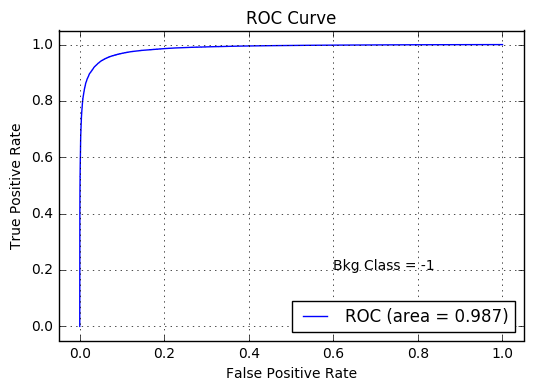

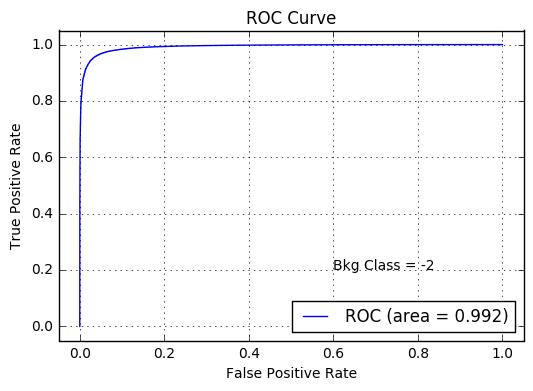

In [108]:
## For one training and one data set
fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
plt.show()
fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
plt.show()

In [201]:
reload(plotting)
## For one training and one data set
#fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
#plt.show()
#fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
#plt.show()
#fpr_dipho_all.append(fpr_dipho)
#tpr_dipho_all.append(tpr_dipho)
#fpr_gJets_all.append(fpr_gJets)
#tpr_gJets_all.append(tpr_gJets)

##if we want to evaluate different trainings on different sets : 


#Be careful to change 0/1 depending whether 2016 or 2017 is first
#scaleFactor_2017 = N_sig_all[1]/N_bkg_all[1]*N_bkg_all[0]/N_sig_all[0]
#for i in range(0,2):
#    if i==1:
#        fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-1,outString=outstr,weights=w_total_test_all[i],newWeight=scaleFactor_2017)
#        fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-2,outString=outstr,weights=w_total_test_all[i],newWeight=scaleFactor_2017)
#    else : 
#        fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-1,outString=outstr,weights=w_total_test_all[i])
#        fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test_all[i],y_total_test_all[i],clf_trainings[i],-2,outString=outstr,weights=w_total_test_all[i])
#    fpr_dipho_all.append(fpr_dipho)
#    tpr_dipho_all.append(tpr_dipho)
#    fpr_gJets_all.append(fpr_gJets)
#    tpr_gJets_all.append(tpr_gJets)

#if we want to evaluate on the same set different trainings : 
for num,clf in enumerate(clf_trainings):
    fpr_dipho,tpr_dipho = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-1,outString=outstr,weights=w_total_test)
    fpr_gJets,tpr_gJets = plotting.plot_roc_curve_multiclass_singleBkg(X_total_test,y_total_test,clf,-2,outString=outstr,weights=w_total_test)
    
    fpr_dipho_all.append(fpr_dipho)
    tpr_dipho_all.append(tpr_dipho)
    fpr_gJets_all.append(fpr_gJets)
    tpr_gJets_all.append(tpr_gJets)
    
roc_curve_file = open(utils.IO.plotFolder+"roc_curves_%s.txt"%outstr,"w") 
roc_curve_file.write("fpr_dipho :\n".join(fpr_dipho_all))
roc_curve_file.write("tpr_dipho :\n".join(tpr_dipho_all))
roc_curve_file.write("fpr_gJets: \n".join(fpr_gJets_all))
roc_curve_file.write("tpr_gJets: \n".join(tpr_gJets_all))
roc_curve_file.close()    

TypeError: sequence item 0: expected string, numpy.ndarray found

In [43]:
print (2.4884508/2.609320423561503)
print (1852.6094/1964.0142)

0.953677738284
0.943276988527


In [71]:
utils.IO.plotFolder = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/%s/'%outstr

In [204]:
#labels_legend = ['2017','2016']
labels_legend = ['w/o res. weighting','with res. weighting bb']
labels = labels_legend

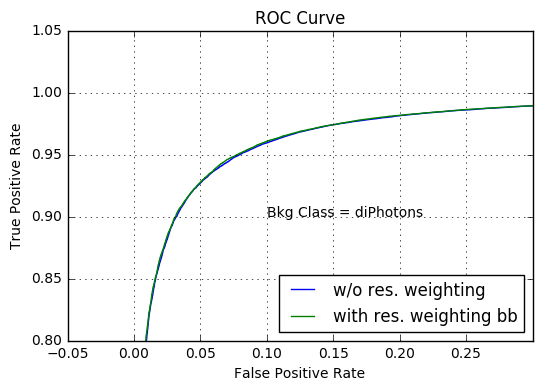

In [205]:
plt.clf()
for i in range(0,len(labels)):
    plt.plot(fpr_dipho_all[i], tpr_dipho_all[i], lw=1, label=labels_legend[i])


#plt.xlim([-0.05, 0.4])
#plt.ylim([0.6, 1.05])
plt.xlim([-0.05, 0.3])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.text(0.1,0.85, 'Bkg Class = diPhotons')
plt.text(0.1,0.9, 'Bkg Class = diPhotons')
plt.grid()
#outString = "comparison_2016_2017_ScaledProperly"
outString = "comparison_resWeighting_bbonly"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_diphotons_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_diphotons_"+str(outString)+".pdf")
plt.show()

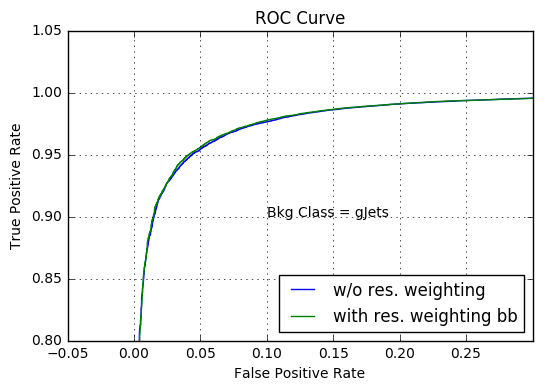

In [206]:
for i in range(0,len(labels)):
    plt.plot(fpr_gJets_all[i], tpr_gJets_all[i], lw=1, label=labels_legend[i])


#plt.xlim([-0.05, 0.4])
#plt.ylim([0.6, 1.05])
plt.xlim([-0.05, 0.3])
plt.ylim([0.8, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
#plt.text(0.1,0.85, 'Bkg Class = gJets')
plt.text(0.1,0.9, 'Bkg Class = gJets')
plt.grid()
#outString = "comparison_2016_2017_ScaledProperly"
outString = "comparison_resWeighting_bbonly"
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_gJets_"+str(outString)+".png")
plt.savefig(utils.IO.plotFolder+"rocCurve"+"_gJets_"+str(outString)+".pdf")
plt.show()

In [208]:
#Compare the performance :

points = [0.80,0.85,0.90,0.95]

#wrt_what= '2016'
wrt_what = 'noResWeighting_bbonly'
for point in points:
    rejections_gJets = []
    rejections_dipho = []
    for i in range(0,2):
        rej_dipho = fpr_dipho_all[i][np.argwhere(tpr_dipho_all[i]>point)[0]]
        print labels[i],' for diphotons : sig. eff. = %.2f , bkg. rej. = %.3f'%(point,rej_dipho)
        rejections_dipho.append(rej_dipho)
    improvement = (rejections_dipho[0]-rejections_dipho[1])/rejections_dipho[1]*100.
    print 'improvement vs %s : %.3f'%(wrt_what,improvement)
    for i in range(0,2):
        rej_gJets = fpr_gJets_all[i][np.argwhere(tpr_gJets_all[i]>point)[0]]
        print labels[i],' for gJets : sig. eff. = %.2f , bkg. rej. = %.3f'%(point,rej_gJets)
        rejections_gJets.append(rej_gJets)
    improvement = (rejections_gJets[0]-rejections_gJets[1])/rejections_gJets[1]*100.
    print 'improvement vs %s : %.3f'%(wrt_what,improvement)
    print 

w/o res. weighting  for diphotons : sig. eff. = 0.80 , bkg. rej. = 0.009
with res. weighting bb  for diphotons : sig. eff. = 0.80 , bkg. rej. = 0.009
improvement vs noResWeighting_bbonly : 5.269
w/o res. weighting  for gJets : sig. eff. = 0.80 , bkg. rej. = 0.004
with res. weighting bb  for gJets : sig. eff. = 0.80 , bkg. rej. = 0.004
improvement vs noResWeighting_bbonly : -2.958

w/o res. weighting  for diphotons : sig. eff. = 0.85 , bkg. rej. = 0.016
with res. weighting bb  for diphotons : sig. eff. = 0.85 , bkg. rej. = 0.016
improvement vs noResWeighting_bbonly : 1.702
w/o res. weighting  for gJets : sig. eff. = 0.85 , bkg. rej. = 0.007
with res. weighting bb  for gJets : sig. eff. = 0.85 , bkg. rej. = 0.007
improvement vs noResWeighting_bbonly : 1.803

w/o res. weighting  for diphotons : sig. eff. = 0.90 , bkg. rej. = 0.032
with res. weighting bb  for diphotons : sig. eff. = 0.90 , bkg. rej. = 0.031
improvement vs noResWeighting_bbonly : 2.435
w/o res. weighting  for gJets : sig. e